# *In vivo* parameter inference from single-molecule mRNA FISH data.

(c) 2017 Manuel Razo. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT). 

In [60]:
import glob
# Our numerical workhorses
import numpy as np
import scipy.optimize
import scipy.special
import scipy.integrate
import mpmath
import pandas as pd
# Import libraries to parallelize processes
from joblib import Parallel, delayed

# Import matplotlib stuff for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

# Seaborn, useful for graphics
import seaborn as sns

# Import the utils for this project
import chann_cap_utils as chann_cap

# Set PBoC plotting style
chann_cap.set_plotting_style()

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline (only use with static plots (non-Bokeh))
%config InlineBackend.figure_format = 'svg'

figdir = '../../fig/chemical_master_mRNA_FISH/'
tmpdir = '../../tmp/'

## $\LaTeX$ macros
$\newcommand{kon}{k_{\text{on}}}$
$\newcommand{koff}{k_{\text{off}}}$
$\newcommand{rm}{r _m}$
$\newcommand{gm}{\gamma _m}$
$\newcommand{mm}{\left\langle m \right\rangle}$

## Exploring the single-molecule mRNA FISH data from Jones et al. 2014.

In this notebook we will explore the use of the raw data from [Jones et al. 2014](http://science.sciencemag.org/content/346/6216/1533) on single molecule mRNA FISH data to make progress in determining parameters for the model.

First of all let's load the data.

In [2]:
df = pd.read_csv('../../data/mRNA_FISH/Jones_Brewster_2014.csv', index_col=0)
df.head()

,area_cells,date,experiment,spots_totals
0,321,20110920,5DL10,0
1,407,20110920,5DL10,4
2,337,20110920,5DL10,3
3,343,20110920,5DL10,2
4,320,20110920,5DL10,0


Now let's plot the raw data for the *lacUV5* promoter used in the project.

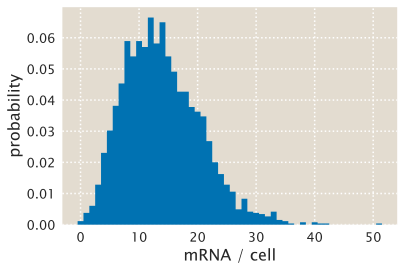

In [56]:
# Extract the lacUV5 data
dfUV5 = df[df.experiment == 'UV5']
# Plot the histogram of the data with bins of width 1
_ = plt.hist(dfUV5.spots_totals, bins=np.arange(0, dfUV5.spots_totals.max()),
             normed=1, histtype='stepfilled', align='left')

# Label the plot
plt.xlabel('mRNA / cell')
plt.ylabel('probability')

# Two-state unregulated promoter model

Given the lack of agreement between the theory and the data at the protein level we will explore the possibility of using a two-state model for the unregulated promter where it transitions from an empty promoter to occupied by RNAP.

[Peccoud & Ycart](http://www.sciencedirect.com/science/article/pii/S0040580985710271) first derived the mRNA distribution for a two-state promoter from the chemical master equation. This distribution is given by
$$
\small
P(m) = {\Gamma\left( {\kon \over \gm} + m \right) \over
        \Gamma (m + 1) \Gamma\left( {\kon + \koff \over \gm} + m \right)}
        {\Gamma\left( {\kon + \koff \over \gm} \right) \over
         \Gamma\left( {\kon \over \gm} \right) } 
         \left( {\rm \over \gm} \right)^m
         {}_1F_1 \left( {\kon \over \gm} + m, {\koff + \kon \over \gm} + m,
                       {-\rm \over \gm} \right),
$$
where ${}_1F_1$ is the confluent hypergeometric function.

[Sanchez & Kondev](http://linkinghub.elsevier.com/retrieve/pii/S1046202313000959) indicate that in the limit where $\koff \gg \kon$, i.e. an alternative form of the weak promoter approximaiton, and also for $\koff > \gm$ the equation simplifies to a Gamma distribution of the form
$$
P(m) = {\left( {\koff \over \rm} \right)^{\kon \over \gm} \over
        \Gamma \left( {\kon \over \gm} \right)}
        m^{{\kon \over \gm} - 1}
        e^{- \left( {\koff \over \rm} m \right)}.
$$

This convenient form of the distribution has a mean mRNA copy number $\mm$ of the form
$$
\mm = {\kon \over \gm} \cdot {\rm \over \koff}.
$$
The variance takes the form
$$
\sigma_m^2 = {\kon \over \gm} \left( {\rm \over \koff} \right)^2.
$$

Therefore the noise $\eta_m$ satisfies
$$
\eta_m^2 = {\sigma_m^2 \over \mm^2} = {\gm \over \kon}.
$$

### Testing the Gamma distribution with the mRNA data

If we assume the Gamma distribution for the mRNA copy number we can estimate the parameters given the data. [Wikipedia](https://en.wikipedia.org/wiki/Gamma_distribution) says that the two parameters of the distribution are
$$
k \equiv {\kon \over \gm}, \;\; \theta \equiv {\rm \over \koff}.
$$

We will use the `scipy.stats.gamma.fit` function to fit the parameters.

In [4]:
gamma_shape, gamma_loc, gamma_scale = \
scipy.stats.gamma.fit(dfUV5.spots_totals.values)

Let's now plot the distribution along with the histogram to compare them side to side.

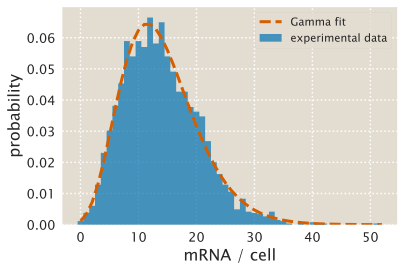

In [57]:
# Extract the lacUV5 data
dfUV5 = df[df.experiment == 'UV5']
# Define bins
bins = np.arange(0, dfUV5.spots_totals.max())
# Plot the histogram of the data with bins of width 1
_ = plt.hist(dfUV5.spots_totals, bins=bins, normed=1, histtype='stepfilled',
             alpha=0.7, label='experimental data', align='left')

pdf = scipy.stats.gamma.pdf(x=bins, a=gamma_shape, 
                            loc=gamma_loc, scale=gamma_scale)
plt.plot(bins, pdf, color='r', ls='--', lw=3, label='Gamma fit')

# Label the plot
plt.xlabel('mRNA / cell')
plt.ylabel('probability')
plt.legend()

Let's now plot the cumulative distribution function.

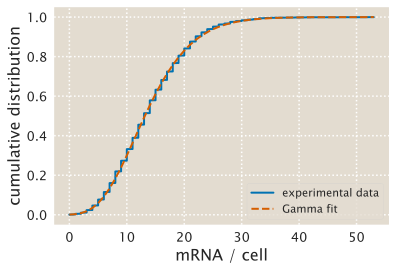

In [6]:
# Compute the empirical CDF
x, y = chann_cap.ecdf(dfUV5.spots_totals.values)
# Compute the theoretical CDF
cdf = scipy.stats.gamma.cdf(x=x, a=gamma_shape, 
                            loc=gamma_loc, scale=gamma_scale)

plt.plot(x, y, label='experimental data')
plt.plot(x, cdf, color='r', ls='--', label='Gamma fit')

plt.xlabel('mRNA / cell')
plt.ylabel('cumulative distribution')
plt.legend()

Now we compute the moments of the distribution.

In [7]:
moments = scipy.stats.gamma.stats(a=gamma_shape, 
                            loc=gamma_loc, scale=gamma_scale, moments='mvsk')
m_mean, m_var, m_skew, m_kurt = [float(x) for x in moments]
print(
'''
mean mRNA : {0:.1f}
var mRNA : {1:.1f}
skewness mRNA : {2:.1f}
kurtosis mRNA : {3:.1f}
'''.format(m_mean, m_var, m_skew, m_kurt)
)


mean mRNA : 13.9
var mRNA : 43.1
skewness mRNA : 0.7
kurtosis mRNA : 0.8



### Inferring back parameters.

Having fit the distribution moments we can compute some parameter ratios. As discussed before the noise $\eta$ would give
$$
\eta_m^2 = {\sigma_m^2 \over \mm^2} = {\gm \over \kon}.
$$

If instead we compute the fano-factor (variance / mean) we can obtain
$$
\text{fano-factor} = {\rm \over \koff}.
$$

Let's compute these paremter ratios.

In [8]:
gamma_m_koff = m_var / m_mean**2
rm_koff = m_var / m_mean
print(
'''
gamma_m / kon = {0:.2f}
r_m / koff = {1:.2f}
'''.format(gamma_m_koff, rm_koff)
)


gamma_m / kon = 0.22
r_m / koff = 3.09



# Issues with this approximation.

This approximation has a several caveat, and that is that the distribution derived by Peccoud & Ycart is **discrete** by nature, while the Gamma distribution is a **continuous** distribution. This obviously comes with its own caveats that need to be extensively studied if one is to make progress with this.

# Parameter inference as defined by Peccoud & Ycart.

In the original paper Peccoud and Ycart define a way to compute three of the parameters given some estimators. The derivation will be left for later, but for now it suffices to say that the parameters can be inferred from experimental data as follows:

The mean mRNA copy number for the full distribution is given by
$$
\mm = {\kon \over \koff + \kon} {\rm \over \gm}.
$$
The variance is given by
$$
\sigma_m^2 = {\rm \over \gm}{\kon \over \kon + \koff} +
             {\kon \koff \over (\kon + \koff)^2}
             {\rm^2 \over \gm (\kon + \koff + \gm)}.
$$


The parameters can be inferred as
\begin{align}
\kon &= {2 r_1 (r_3 - r_2) \over r_1 r_2 - 2 r_1 r_3 + r_2 r_3},\\
\koff &= {2 (r_2 - r_1)(r_1 - r_3)(r_3 - r_2) \over
          (r_1 r_2 - 2 r_1 r_3 + r_2 r_3)(r_1 - 2 r_2 + r_3)},\\
\rm &= {-r_1 r_2 + 2 r_1 r_3 - r_2 r_3 \over r_1 - 2 r_2 + r_3},
\end{align}
where $r_i$ are the successive ratios of the exponential moments, i.e.
\begin{align}
r_1 &= \mm \\
r_2 &= {\left\langle m^2 \right\rangle \over \mm} , \\
r_2 &= {\left\langle m^3 \right\rangle \over \left\langle m^2 \right\rangle}.
\end{align}

The best estimators for these moments are given by
\begin{align}
\widehat\mm &= {1 \over N} \sum_{i=1}^N x_i,\\
\widehat{\left\langle m^2 \right\rangle} &= {1 \over N} \sum_{i = 1}^N 
                                             x_i (x_i - 1)\\
\widehat{\left\langle m^3 \right\rangle} &= {1 \over N} \sum_{i = 1}^N 
                                             x_i (x_i - 1) (x_i - 2).
\end{align}

Let's use all these equations to compute the parameter values.

In [65]:
# Extract parameters to compute moments
mRNA = dfUV5.spots_totals.values
N = len(mRNA)

# 1. Compute the moments estimators
m_first = 1 / N * np.sum(mRNA)
m_second = 1 / N * np.sum(mRNA * (mRNA - 1))
m_third = 1 / N * np.sum(mRNA * (mRNA - 1) * (mRNA - 2))

# 2. Compute moment ratios
r1 = m_first
r2 = m_second / m_first
r3 = m_third / m_second

# 3. Compute parameters
kon_UV5 = 2 * r1 * (r3 - r2) / (r1 * r2 - 2 * r1 * r3 + r2 * r3)
koff_UV5 = 2 * (r2 - r1) * (r1 - r3) * (r3 - r2) / \
           ((r1 * r2 - 2 * r1 * r3 + r2 * r3) * (r1 - 2 * r2 + r3))
rm_UV5 = (- r1 * r2 + 2 * r1 * r3 - r2 * r3) / \
         (r1 - 2 * r2 + r3)
    
# 4. Compute the values knowing the gamma_m value
gamma_m = 0.00284
kon = kon_UV5 * gamma_m 
koff = koff_UV5 * gamma_m
rm = rm_UV5 * gamma_m

print(
'''
Parameter values
----------------
kon  = {0:.3f} s^-1
koff = {1:.3f} s^-1
rm   = {2:.3f} s^-1
'''.format(kon, koff, rm)
)


Parameter values
----------------
kon  = 0.017 s^-1
koff = 0.132 s^-1
rm   = 0.354 s^-1



### Testing the parameters by computing the complete two-state distribution of mRNA.

Having obtained what looks like reasonable parameter values let's now define a function that computes the probability mass function for our discrete distribution. We will compute the log probability since this is numerically more stable. The only caveat is that `scipy`'s implementation of the hypergeometric function is not completely stable, so we will use the `mpmath` implementation instead.

In [66]:
# define a np.frompyfunc that allows us to evaluate the sympy.mp.math.hyp1f1
np_log_hyp= np.frompyfunc(lambda x, y, z: \
mpmath.ln(mpmath.hyp1f1(x, y, z, zeroprec=1000)), 3, 1)

def log_p_m_unreg(mRNA, kon, koff, gamma_m, r_m):
    '''
    Computes the log probability lnP(m) for an unregulated promoter, 
    i.e. the probability of having m mRNA.
    
    Parameters
    ----------
    mRNA : float.
        mRNA copy number at which evaluate the probability.        
    kon : float.
        rate of activation of the promoter in the chemical master equation
    koff : float.
        rate of deactivation of the promoter in the chemical master equation
    gamma_m : float.
        1 / half-life time for the mRNA.
    r_m : float.
        production rate of the mRNA
    
    Returns
    -------
    log probability lnP(m)
    '''
    # Convert the mRNA copy number to a  numpy array
    mRNA = np.array(mRNA)
    
    # Compute the probability
    lnp = scipy.special.gammaln(kon / gamma_m + mRNA) \
    - scipy.special.gammaln(mRNA + 1) \
    - scipy.special.gammaln((koff + kon) / gamma_m + mRNA) \
    + scipy.special.gammaln((koff + kon) / gamma_m) \
    - scipy.special.gammaln(kon / gamma_m) \
    + mRNA * np.log(r_m / gamma_m) \
    + np_log_hyp(kon / gamma_m + mRNA,
            (koff + kon) / gamma_m + mRNA, -r_m / gamma_m)
    
    return lnp.astype(float)

Having defined this function let's compare the theoretical prediction with the experimental data!

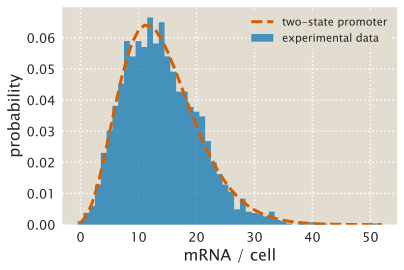

In [68]:
# Define bins
bins = np.arange(0, dfUV5.spots_totals.max())

logp_mRNA = log_p_m_unreg(bins, kon, koff, gamma_m, rm)

# Plot the histogram of the data with bins of width 1
_ = plt.hist(dfUV5.spots_totals, bins=bins, normed=1, histtype='stepfilled',
             alpha=0.7, label='experimental data', align='left')

plt.plot(bins, np.exp(logp_mRNA), color='r', ls='--', lw=3,# drawstyle='steps',
         label='two-state promoter')

# Label the plot
plt.xlabel('mRNA / cell')
plt.ylabel('probability')
plt.legend()
plt.savefig(figdir + 'lacUV5_two_state_PMF_fit.png')

Let's now look at the CDF.

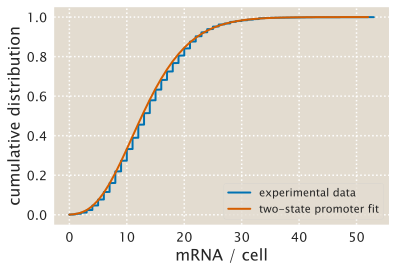

In [69]:
# Compute the empirical CDF
x, y = chann_cap.ecdf(dfUV5.spots_totals.values)
# Compute the theoretical CDF
cdf = np.cumsum(np.exp(logp_mRNA))

plt.plot(x, y, label='experimental data')
plt.plot(bins, cdf, color='r', ls='-', label='two-state promoter fit')
#          drawstyle='steps')

plt.xlabel('mRNA / cell')
plt.ylabel('cumulative distribution')
plt.legend()
plt.savefig(figdir + 'lacUV5_two_state_CDF_fit.png')

The agreement between theory and data seems to be very promising!
That means that the parameters inferred could be potentially meaningful.